In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random
# import png

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16053908395496102038
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2685209271252005797
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5709498845961328850
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

In [5]:
miceList = getMiceList(Files[0])
miceList.remove('1253')
miceList.remove('1231')
mOrder = np.random.permutation(len(miceList))

mTrain = ['1231', '1253']
mValidate =[miceList[i] for i in mOrder[:2]]
mTest =  [miceList[i] for i in mOrder[2:4]]
mTrain = mTrain+ [miceList[i] for i in mOrder[4:]]

print(mTrain,mValidate,mTest)
# print(miceList[mOrder[:2]])

['1231', '1253', '0761', '8815', '1793', '1222', '4539', '8430', '7584', '2976', '7909', '1208'] ['1236', '8803'] ['2980', '2981']


In [6]:
data_train = getData(Files[0],['lfp','speed'],period ='Pre', mice=mTrain)
data_validate = getData(Files[0],['lfp','speed'],period ='Pre', mice=mValidate)
data_test = getData(Files[0],['lfp','speed'],period ='Pre', mice=mTest)

cleaning up lfp data
I deleted session: 2976_day4
I deleted session: 1208_day12
cleaning up speed data
cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data


In [ ]:
df = pd.DataFrame(column = ['speed','lfp','label'])
dtL = 0.0032768
tPlot = np.linspace(-8,8,int(16/dtL-1))
sess = '2980_BaselineA'
# for sess in tqdm(data_test.keys()):
if sess[5] == 'B':
    day = 0
else:
    day = int(re.findall(r'\d+',sess[5:])[0])

# get data
speed = data_test[sess]['speed']['speed']
caT = np.arange(max(speed.shape))*0.05
speedF = sci.interpolate.interp1d(caT, speed,kind='linear')
period = periodCalc(day)
LFP = data_test[sess]['lfp']['lfp']
lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
LFP = LFP[(lfpOutliers[:,0]==0),0]
a = sci.signal.decimate(LFP,10,axis=0)
lfpT = np.arange(max(a.shape))*dtL

In [144]:
# add speed data:
from matplotlib import image as pltI
savePath = "E:\\data\\"
dtL = 0.0032768
tPlot = np.linspace(-8,8,int(16/dtL-1))
f = h5py.File('D:\\6OHDA\\Spectograms.hdf5','r') 
for g in ['Test','Validate','Train']: #'Train','Validate',
    mList = eval("m"+g)
    sPath = savePath+g+"\\"
    for m in tqdm(mList):
        data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
        for sess in data:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            speed = data[sess]['speed']['speed']
            caT = np.arange(max(speed.shape))*0.05
            speedF = sci.interpolate.interp1d(caT, speed,kind='linear')

            period = periodCalc(day)
            freq = f[m][sess]['Pre']['freq'][:]
            coeff = np.abs(f[m][sess]['Pre']['coeff'][:])
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff = coeff[:,(lfpOutliers[:,0]==0)]
            coeff = coeff.T*freq
            Hs = np.nansum(coeff, axis=1)
            coeff = coeff.T/Hs.T
            coeff = coeff.T
            a = sci.signal.decimate(coeff,10,axis=0)

            lfpT = np.arange(max(a.shape))*dtL
            if max(caT)< max(lfpT):
                endInd = np.argmin(np.abs(max(caT)-lfpT))
                print(endInd)
                while lfpT[endInd]>max(caT):
                    endInd = endInd-1
            speedNew = speedF(lfpT[:endInd])
            speedNew = (speedNew-np.min(speedNew))/(np.max(speedNew)-np.min(speedNew))/5
            a = np.hstack((a[:endInd,:],speedNew.T))

            del coeff
            A = [a[i : i + tPlot.shape[0],:] for i in range(0, a.shape[0],int(np.ceil(2/dtL)))] 
            if g == 'Test':
                sPathSess = sPath + 'unlabeled\\'
            else:
                sPathSess = sPath +period+'\\'
            for ind,img in enumerate(A):
                z = (65535*((img - np.nanmin(img))/( np.nanmax(img)- np.nanmin(img)))).astype(np.uint16)
                pltI.imsave(sPathSess+'{m:s}_{p:s}_{ind:d}.png'.format(m=sess,p=period,ind=ind), z)
                

                

                


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data
181549
181564
181549
181564
181549
181564
181549
181549
181564
181564
181549
181564
181564
181564


 50%|█████████████████████████████████████████▌                                         | 1/2 [16:35<16:35, 995.17s/it]

cleaning up lfp data
cleaning up speed data
181549
181549
181549
181549
181549
181564
181549
181549
181549
181564
181549
181564
181549
181549


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
181549
181564
181549
181549
181549
181534
181564
181564
181534
found  888231.0  outlier points
found  481139.0  outlier points
181549
181549
181549


 50%|█████████████████████████████████████████▌                                         | 1/2 [14:50<14:50, 890.33s/it]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
181549
181564
181549
181549
181549
181549
found  17.0  outlier points
181564
181534
181549
181549
181564
181564
181564


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data
181549
181564
181564


  8%|██████▊                                                                           | 1/12 [02:46<30:36, 166.93s/it]

cleaning up lfp data
cleaning up speed data
181549
181549
181549


 17%|█████████████▋                                                                    | 2/12 [05:57<30:05, 180.55s/it]

cleaning up lfp data
cleaning up speed data
181549
181549
181549
161240
181549
181534
181549
181549
181564
181564
181564
181564
163162
181564


 25%|████████████████████                                                            | 3/12 [21:42<1:19:28, 529.84s/it]

cleaning up lfp data
cleaning up speed data
181564
181564
181549
181564
181549
181549
181549
181549
181564
181549
181564
181549
181564
181564


 33%|██████████████████████████▋                                                     | 4/12 [35:43<1:27:00, 652.58s/it]

cleaning up lfp data
cleaning up speed data
181549
181549
181549
181534
181549
181564
181564
181564
181549
181549
181564
181564
181549
181564
181564
181549
181549
181564
181564


 42%|█████████████████████████████████▎                                              | 5/12 [56:24<1:40:53, 864.72s/it]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points
181564
181564
181549
181549
181549
181564
181549
181564
181549
181549
181549
181564
found  3.0  outlier points
181549


 50%|███████████████████████████████████████                                       | 6/12 [1:11:52<1:28:39, 886.51s/it]

cleaning up lfp data
cleaning up speed data
181549
181549
181564
181564
found  29.0  outlier points
181564
181549
181564
181564
181564
181549
181534
181549
181549
181564
181549
181549
181549
181549
181564


 58%|█████████████████████████████████████████████▌                                | 7/12 [1:31:34<1:21:54, 982.89s/it]

cleaning up lfp data
cleaning up speed data
181549
181549
181549
181549
181549
181564
181564
181564
181549
181564
181564
181564
181564
181534


 67%|████████████████████████████████████████████████████                          | 8/12 [1:46:35<1:03:47, 956.85s/it]

cleaning up lfp data
cleaning up speed data
181549
181549
181564
181564
181549
181549
181549
181564
181549
181564
181549
181564
181564


 75%|████████████████████████████████████████████████████████████                    | 9/12 [1:59:30<45:00, 900.17s/it]

cleaning up lfp data
cleaning up speed data
181564
181564
181549
181549
181564
181549
181549
181549
181564
181549
181549
181549
181549
181534
181549
181564
181549


 83%|█████████████████████████████████████████████████████████████████▊             | 10/12 [2:17:14<31:41, 950.60s/it]

cleaning up lfp data
cleaning up speed data
181549
181549
181549
181549
181564
181564
181564
181549
181549
181564
181549
181549
178116
181549


 92%|████████████████████████████████████████████████████████████████████████▍      | 11/12 [2:33:58<16:06, 966.85s/it]

cleaning up lfp data
cleaning up speed data
181549
181564
181549
181549
181564
181564
found  50.0  outlier points
181564
181549
181564
181549
144867
181564
181564


100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [2:48:54<00:00, 844.52s/it]


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)#(rescale = 1./65535)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)#(rescale = 1./65535)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)#(rescale = 1./65535) #rescale=1./255
train_generator = train_datagen.flow_from_directory(
    directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
    target_size=(600, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=36
)
validate_generator = valid_datagen.flow_from_directory(
    directory="E:\\data\\Validate\\",#'E:\\data\\imageTest\\test_set\\',#
    target_size=(600, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory="E:\\data\\Test\\",#'E:\\data\\imageTest\\test_set\\',#
    target_size=(600, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode=None,
    shuffle=False
)



Found 46656 images belonging to 3 classes.
Found 7833 images belonging to 3 classes.
Found 8344 images belonging to 1 classes.


In [6]:
# calculate the class weight: - flow from directory goes alphabetically so Acute, Chroniq, Healthy
files_per_class = []
for folder in ['Acute','Chronic','Healthy']:
    if not os.path.isfile("E:\\data\\Train\\"+folder):
            files_per_class.append(len(os.listdir("E:\\data\\Train\\"+folder)))
total_files = sum(files_per_class)
class_weights = {}
print(files_per_class)
for i in range(len(files_per_class)):
    class_weights[i] = (1 /(float(files_per_class[i]))) *( total_files/2)

print(class_weights)

[23114, 12814, 10728]
{0: 1.0092584580773556, 1: 1.820508818479788, 2: 2.174496644295302}


<IPython.core.display.Javascript object>


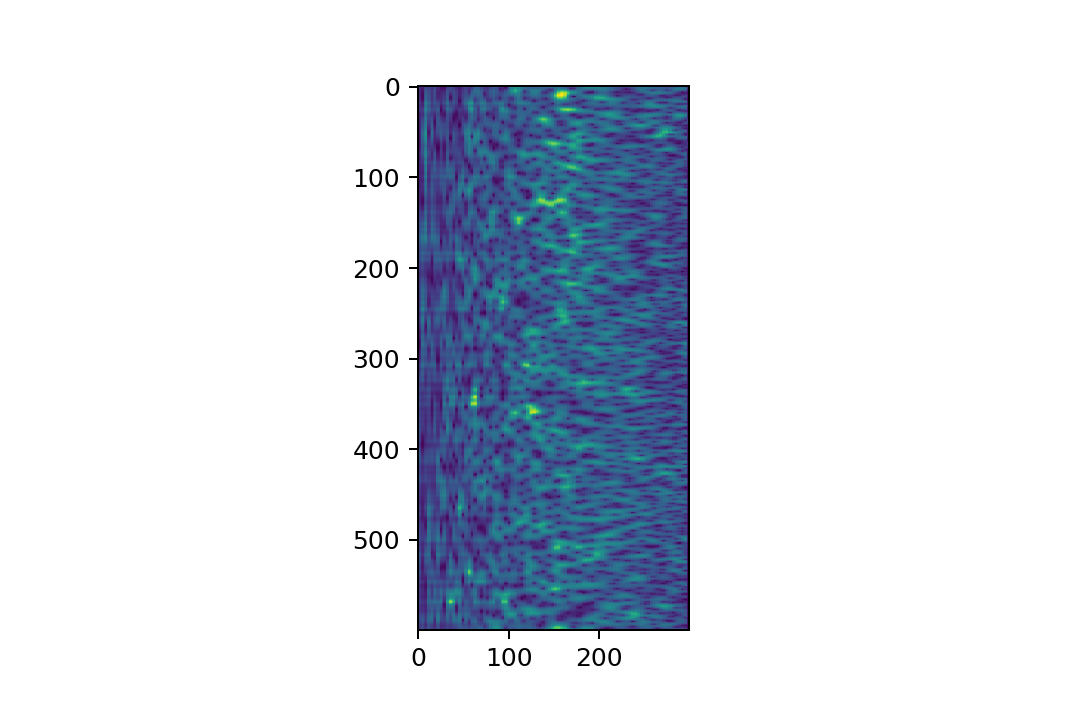

(32, 600, 300, 1)
0.11764707 0.8431373


In [158]:
a = test_generator.next()
plt.imshow(a[4,:,:,0])
print(a.shape)
print(np.min(a[:,:,:,0]),np.max(a[:,:,:,0]))

In [166]:
del model

In [7]:
# model for v4
mix_layer = []
inputShape = (600,300,1)
inp = Input(shape=inputShape)
convs = []
kernel_size= {}
kernel_size[0]= (40,10)
kernel_size[1]= (5,15)
for k_no in range(len(kernel_size)):
    conv = Conv2D(16, kernel_size[k_no],activation='relu',
                  padding='SAME',input_shape=inputShape)(inp)
    pool = MaxPooling2D(pool_size=(2,2))(conv)
    mix_layer.append(pool)
out = Concatenate()(mix_layer)
conv_model = Model(inputs=inp, outputs=out)

model = Sequential()
model.add(conv_model) 
model.add(Dropout(0.40))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.40))


# model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))#,kernel_initializer=initializer))
model.add(Flatten())
# model.add(Dense(50, activation='relu'))#,kernel_initializer=initializer))
model.add(Dense(3, activation='softmax'))

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 300, 150, 32)      7632      
_________________________________________________________________
dropout (Dropout)            (None, 300, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 298, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 49, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 155232)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [10]:
modelName = 'LFP_period_v12'

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

stepTrain=train_generator.n//train_generator.batch_size
stepValidate=validate_generator.n//validate_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=stepTrain,
                    validation_data=validate_generator,
                    validation_steps=stepValidate,
                    epochs=500,class_weight=class_weights,callbacks=[early_stopping])#,


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
1458/1458 [==============================] - 516s 352ms/step - loss: 1.6517 - accuracy: 0.3165 - val_loss: 1.0970 - val_accuracy: 0.3837
Epoch 2/500
1458/1458 [==============================] - 518s 355ms/step - loss: 1.6450 - accuracy: 0.3589 - val_loss: 1.1016 - val_accuracy: 0.2723
Epoch 3/500
1458/1458 [==============================] - 514s 352ms/step - loss: 1.6341 - accuracy: 0.3716 - val_loss: 1.1058 - val_accuracy: 0.2975
Epoch 4/500
1458/1458 [==============================] - 512s 351ms/step - loss: 1.5997 - accuracy: 0.4324 - val_loss: 1.1001 - val_accuracy: 0.3495
Epoch 5/500
1458/1458 [==============================] - 513s 352ms/step - loss: 1.5756 - accuracy: 0.4486 - val_loss: 1.1276 - val_accuracy: 0.3340
Epoch 6/500
1458/1458 [==============================] - 513s 352ms/step - loss: 1.5560 - accuracy: 0.4587 - val_loss

1458/1458 [==============================] - 513s 352ms/step - loss: 1.0105 - accuracy: 0.6961 - val_loss: 1.1633 - val_accuracy: 0.3758
Epoch 54/500
1458/1458 [==============================] - 512s 351ms/step - loss: 1.0023 - accuracy: 0.6965 - val_loss: 1.1817 - val_accuracy: 0.3782
Epoch 55/500
1458/1458 [==============================] - 512s 351ms/step - loss: 0.9972 - accuracy: 0.7015 - val_loss: 1.1995 - val_accuracy: 0.3870
Epoch 56/500
1458/1458 [==============================] - 514s 353ms/step - loss: 0.9849 - accuracy: 0.7033 - val_loss: 1.2053 - val_accuracy: 0.3755
Epoch 57/500
1458/1458 [==============================] - 515s 353ms/step - loss: 0.9749 - accuracy: 0.7068 - val_loss: 1.2058 - val_accuracy: 0.3708
Epoch 58/500
1458/1458 [==============================] - 517s 355ms/step - loss: 0.9780 - accuracy: 0.7082 - val_loss: 1.1597 - val_accuracy: 0.3663
Epoch 59/500
1458/1458 [==============================] - 515s 353ms/step - loss: 0.9767 - accuracy: 0.7078 - val

In [11]:
## Saving the model
##
model.save('E:\\'+modelName)
model.save_weights('E:\\'+modelName+'_weights.h5')

INFO:tensorflow:Assets written to: E:\LFP_period_v12\assets


In [ ]:
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])# history.history

In [13]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

labels = (train_generator.class_indices)
pred = model.predict_generator(test_generator,verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for f in test_generator.filenames:
    sess = f.split("_")[1]
    if sess[0] == 'B':
        day = 0
    else:
        day = int(re.findall(r'\d+',sess)[0])

    # get data
    period = periodCalc(day) 
    y.append(labels[period])

C:\Users\dzemel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


261/261 [==============================] - 156s 598ms/step
[0 1 2]


0.438758389261745


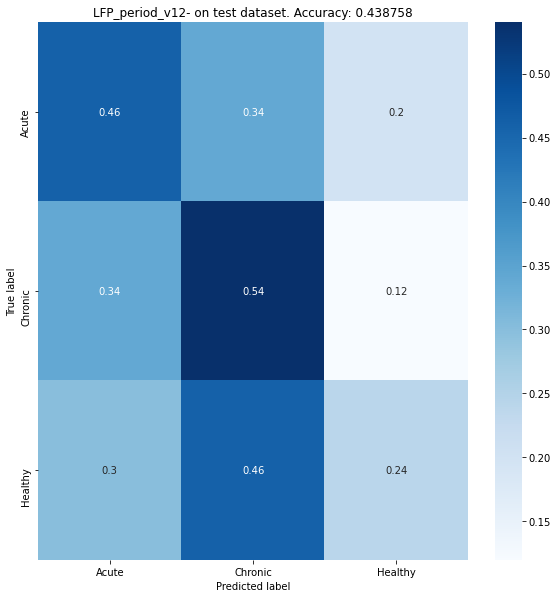

In [14]:
classes=labels.keys()
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on test dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Test.png")
print(np.sum(y==pred)/len(y))

In [71]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# train_datagenT = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# train_generatorT = train_datagenT.flow_from_directory(
#     directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
#     target_size=(300, 300),
#     color_mode="grayscale",
#     batch_size=32,
#     class_mode="categorical",
#     shuffle=False,
#     seed=36
# )


labels = (train_generator.class_indices)
pred = model.predict_generator(train_generatorT,verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for f in train_generatorT.filenames:
    sess = f.split("_")[1]
    if sess[0] == 'B':
        day = 0
    else:
        day = int(re.findall(r'\d+',sess)[0])

    # get data
    period = periodCalc(day) 
    y.append(labels[period])

567/567 [==============================] - 89s 157ms/step
[0 1 2]


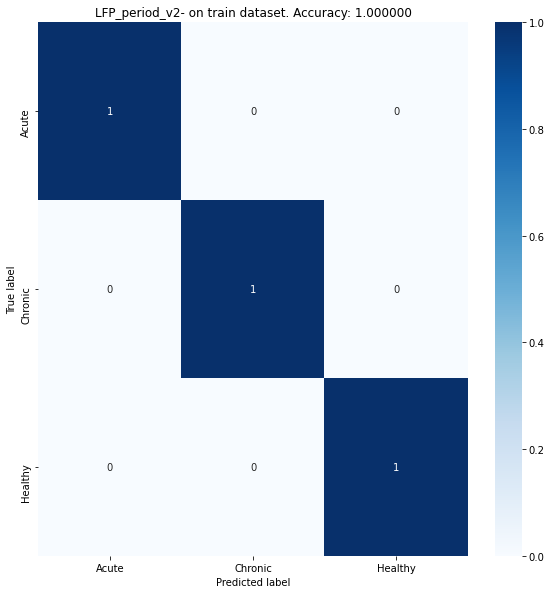

In [73]:
classes=labels.keys()
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on train dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Train.png")


In [61]:
score = model.evaluate(train_generatorT)
print(score)

567/567 [==============================] - 89s 157ms/step - loss: 3.5345e-04 - accuracy: 1.0000
[0.00035344576463103294, 1.0]


In [56]:
pred = model.predict_generator(train_generator,verbose=1)
pred.shape

567/567 [==============================] - 89s 157ms/step


(18130, 3)

In [57]:
train_generatorT = train_datagen.flow_from_directory(
    directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
    target_size=(300, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=36
)


array([[9.9993336e-01, 6.6623645e-05, 2.0047966e-09],
       [1.0000000e+00, 1.3673330e-08, 4.0443326e-10],
       [3.7493074e-08, 1.0000000e+00, 1.9402356e-11],
       [3.0466440e-04, 9.9913293e-01, 5.6242698e-04]], dtype=float32)

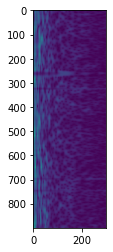

In [85]:
%matplotlib inline
for d,l in train_generator:
    plt.imshow(d[16,:,:,0])
    break